# Exploratory Data Analysis (EDA)


## Libraries, Modules, and Configuration File

In [41]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
PATH = "/home/er_bim/ML-Process-Final-Project-Feb23-Bimo/"
sys.path.append(PATH)
import src.util as utils
config = utils.load_config()

import warnings
warnings.filterwarnings('ignore')


## Inspecting the data distribution.
The EDA works are applied only for the training data.


In [42]:
# Loading Dataset 
x_train = utils.pkl_load(config["dataset_train_path"][0])
y_train = utils.pkl_load(config["dataset_train_path"][1])

EDA_df = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
utils.pkl_dump(EDA_df, config["dataset_EDA_path"])

# Separate the numerical and categorical data types
numerical_columns = EDA_df._get_numeric_data().columns
categorical_columns = (EDA_df.drop(numerical_columns, axis=1)).columns.values.tolist()


In [43]:
# Create the function for data visualization.
def draw_histograms(dataset, features, n_rows, n_cols, bins):
    """A function to visualize the multiple graphs of the features
    for an introductory observation to the dataset"""
    fig = plt.figure()
    for i, var_name in enumerate(features):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        dataset[var_name].hist(bins = bins, ax=ax, color = 'green', figsize = (50, 50))
        ax.set_title(var_name, fontsize = 50)
        ax.tick_params(labelsize = 40, grid_alpha = 0.7)
    fig.tight_layout() 
    plt.show()

### Numerical Data Distribution.


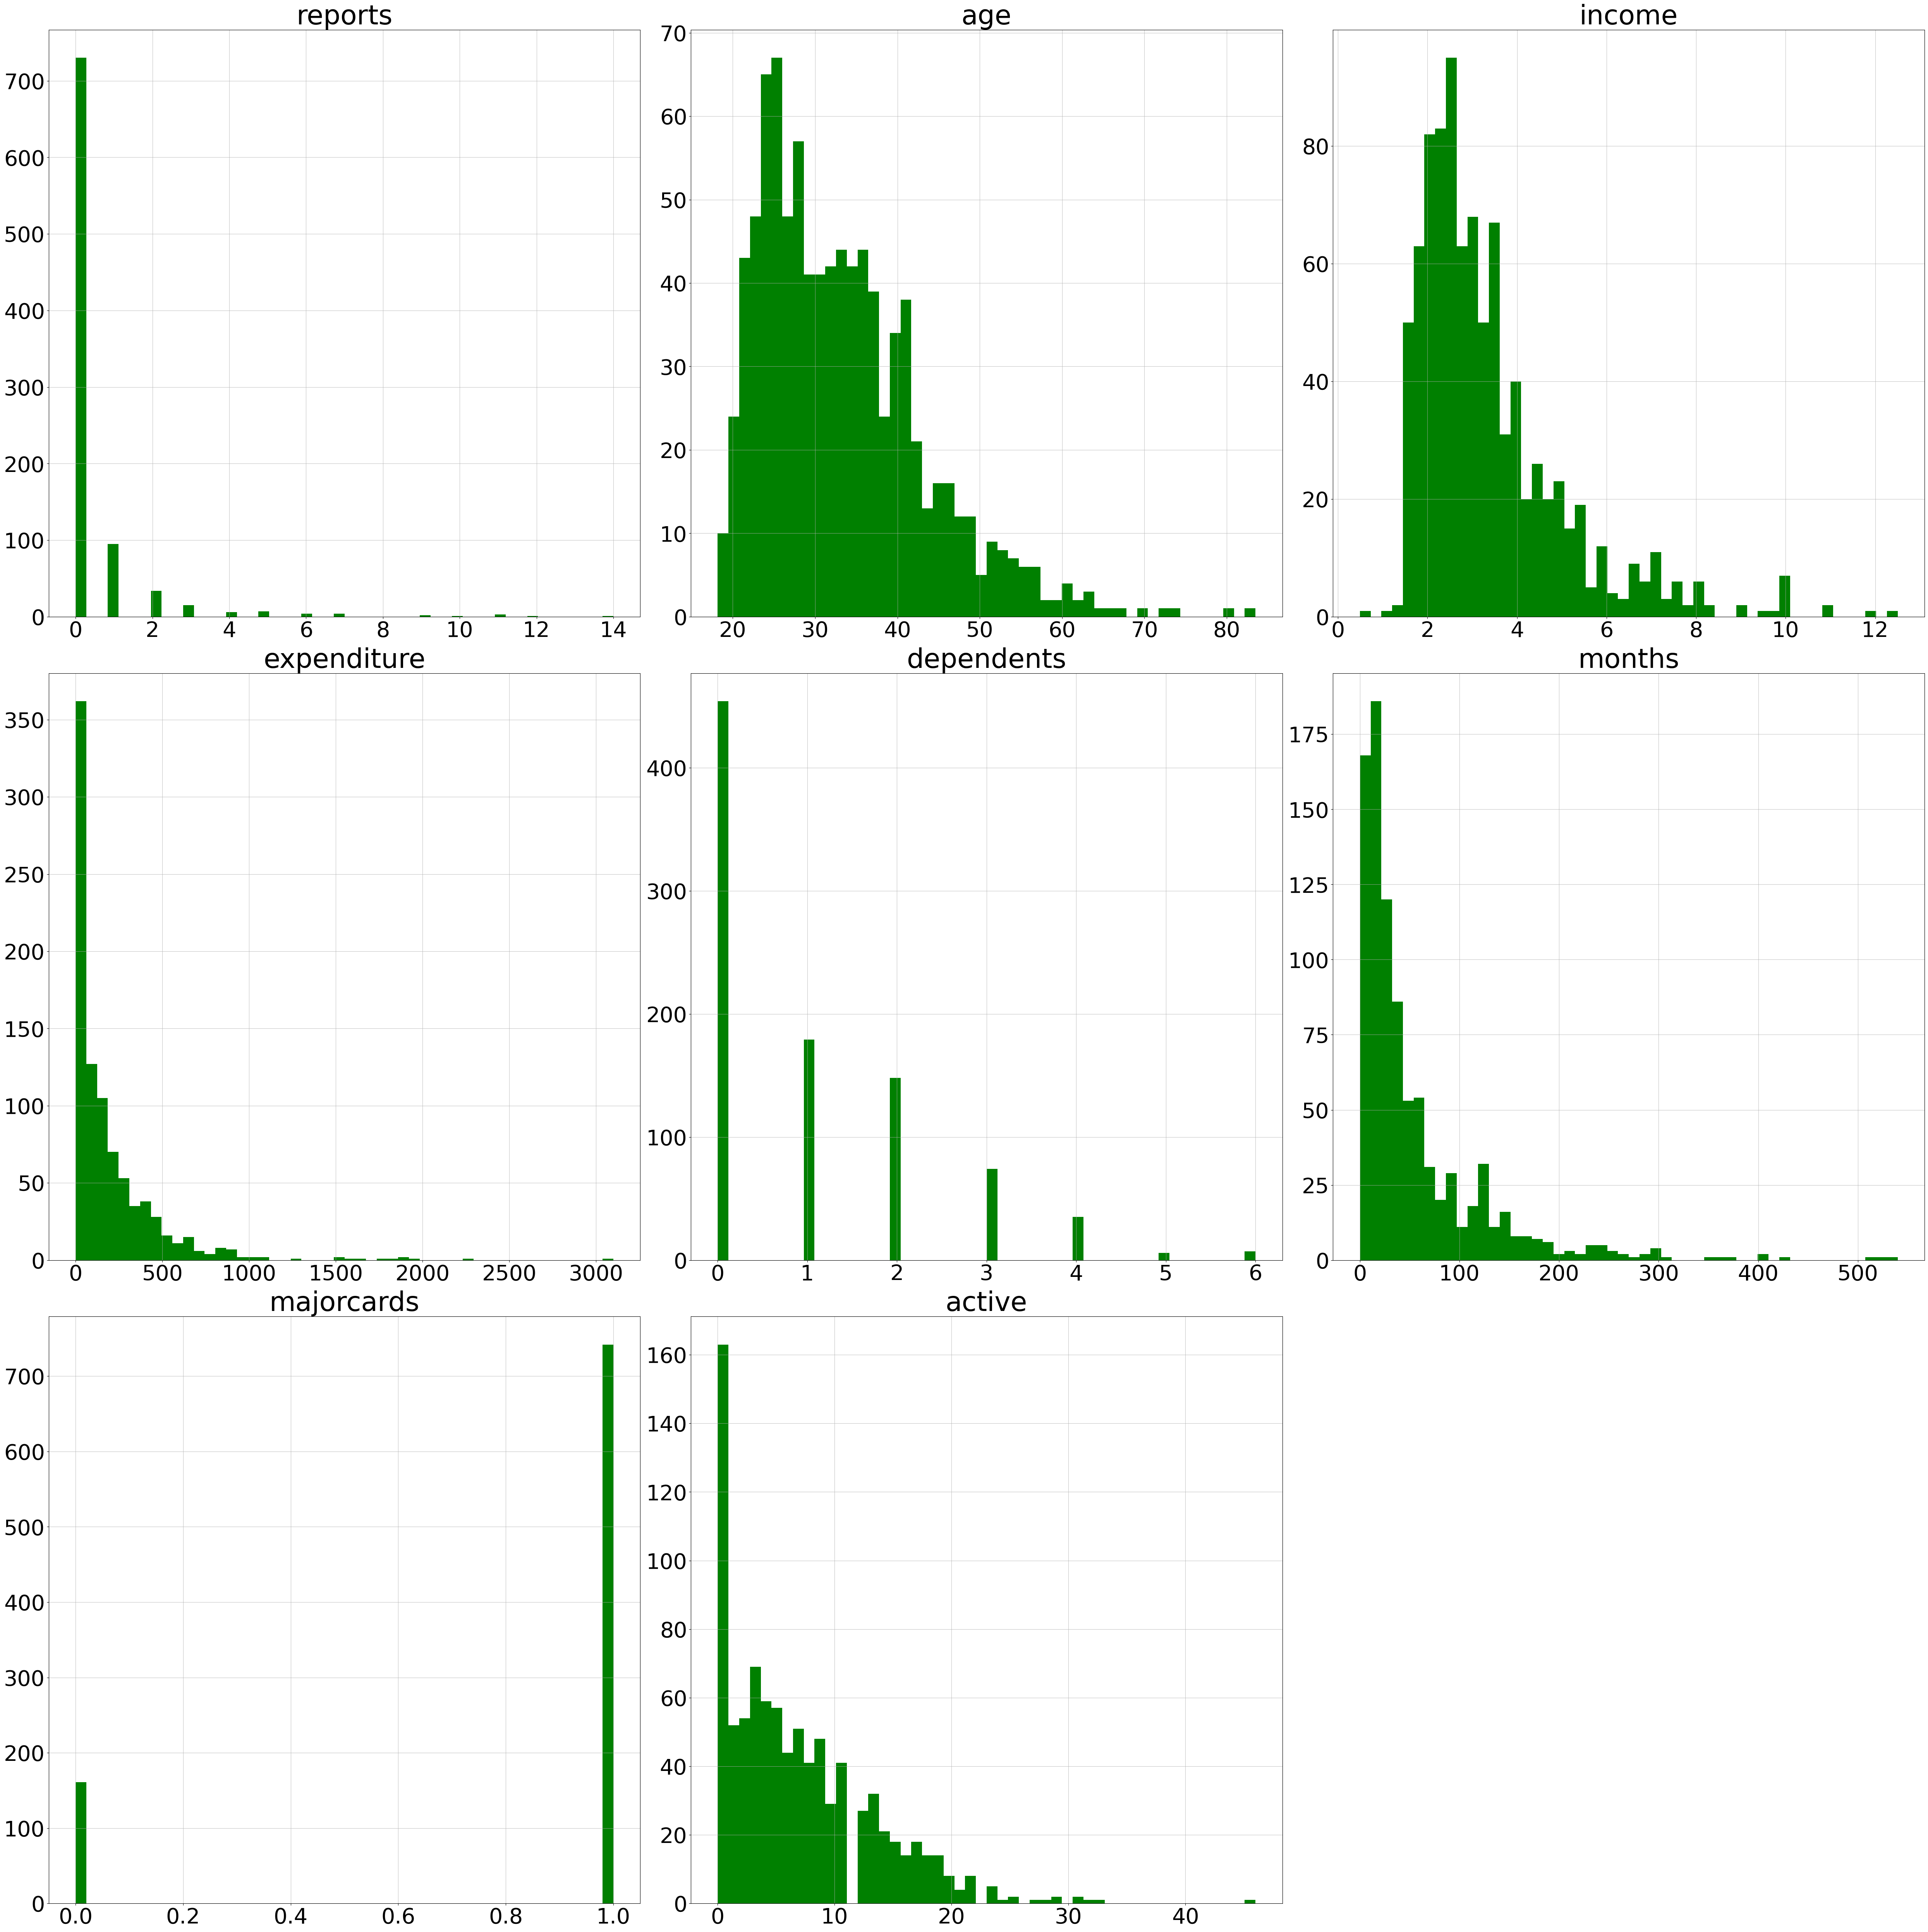

In [44]:
# Visualize the numerical data distribution
draw_histograms(EDA_df, numerical_columns, 3, 3, 50)

Next, I will analyze deeper into the numerical columns.


#### Detail EDA on each feature.


In [45]:
# Create the function for specific numerical column data visualization.
def check_dist(col, bins=50, density=False, plot_normal=True, log_bins=False):
  """A function to visualize the graph for inspecting each feature thoroughly,
  in addition to the basic bar plot of the feature, the graph also shows the normal distribution curve, mean and median vertical lines.
  The correlation to the dependent/target feature is visualized by the KDE plot."""

  x = EDA_df[col]
  TARGET = EDA_df['card']

  fig, ax = plt.subplots(figsize=(8,6))
  fig.suptitle(f"Distribution of {str(col).upper()}")
  sns.distplot(x, axlabel=x.name, color = "green")
  sns.kdeplot(EDA_df.loc[TARGET == "yes", col] , label = 'Approved')
  sns.kdeplot(EDA_df.loc[TARGET == "no", col] ,  label = 'Not Approved')
  line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
  line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
  first_legend = plt.legend(handles=[line1,line2], loc=1)

  if plot_normal == True:
    mu, std = stats.norm.fit(x)
    xmin, xmax = plt.xlim()
    x_norm = np.linspace(xmin, xmax, 100)
    pdf = stats.norm.pdf(x_norm, mu, std)
    ax.plot(x_norm, pdf, 'k', linewidth=2, label=f"normal distribution\n(mu=mean, std:{std:.2f}")

  ax.legend()
  fig.show()
  print(x.describe())
  print("Median:", x.median())

##### reports


count    903.000000
mean       0.449612
std        1.396645
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       14.000000
Name: reports, dtype: float64
Median: 0.0


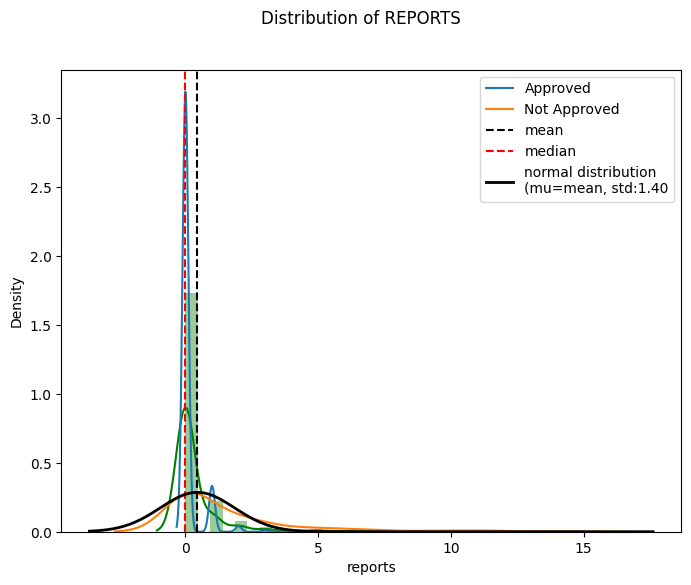

In [46]:
check_dist(numerical_columns[0])

Most applicants have no major derogatory reports.

##### age


count    903.000000
mean      33.228313
std        9.955114
min       18.166670
25%       25.250000
50%       31.500000
75%       38.916670
max       83.500000
Name: age, dtype: float64
Median: 31.5


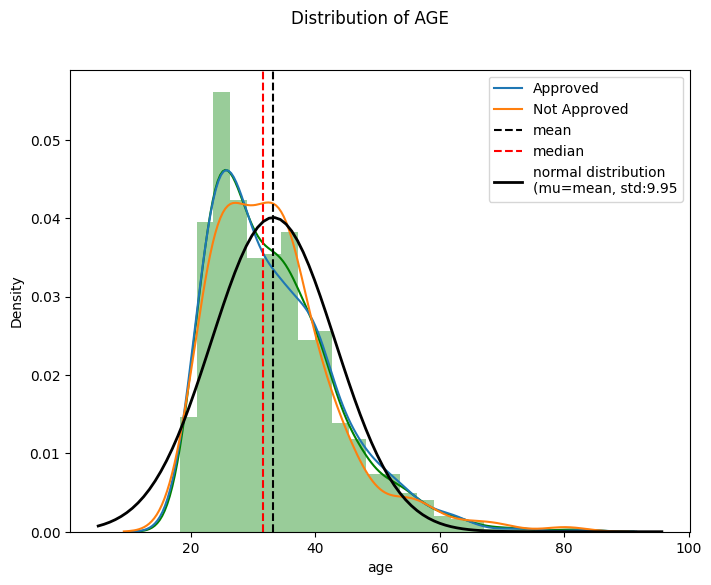

In [47]:
check_dist(numerical_columns[1])

This feature is already handled by dropping the data valued under 18 in the Data Pipeline chapter.


##### income


count    903.000000
mean       3.384004
std        1.678448
min        0.490000
25%        2.250000
50%        2.950000
75%        4.000000
max       12.499900
Name: income, dtype: float64
Median: 2.95


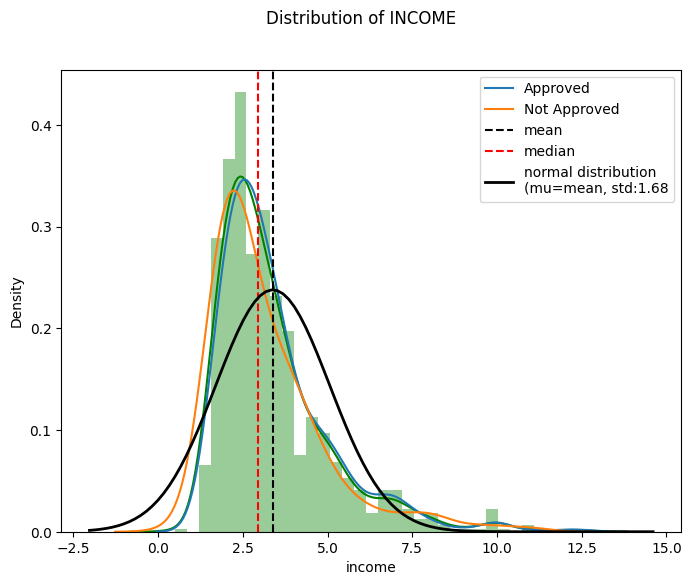

In [48]:
check_dist(numerical_columns[2])

The values shown in this feature are divided by 10,000.

There are some notable occurrence of applicants whose incomes are around 10, we need to inspect it further.


In [49]:
EDA_df.loc[(EDA_df['income'] >= 10)]

,reports,age,income,expenditure,owner,selfemp,dependents,months,majorcards,active,card
85,0,45.58333,11.9999,200.49330,yes,yes,1,24,1,6,yes
359,1,32.50000,10.0000,308.25000,yes,no,3,35,1,4,yes
441,0,31.75000,10.9999,97.42416,no,no,0,12,1,0,yes
584,0,51.58333,12.4999,3099.50500,yes,no,1,120,1,21,yes
645,0,53.00000,11.0000,0.00000,yes,yes,0,429,1,0,no
861,0,43.66667,10.0393,182.82500,yes,no,1,12,1,18,yes


The higher income means the more probable the application to be approved.

Moreover, the applicant's income is more than $100,000 per year, the probability of an application being approved is near 100%.

We can see the exception at the table above, the only one applicant whose income more than $100,000 per year and not approved have zero expenditure.

I decide to keep all the data in this feature, perhaps the model will the threshold of approval decision at 10 or there will be any significant weight from another feature that can affect the approval decision.


##### expenditure


count     903.000000
mean      194.336055
std       287.297197
min         0.000000
25%         5.364583
50%       105.507500
75%       265.921250
max      3099.505000
Name: expenditure, dtype: float64
Median: 105.5075


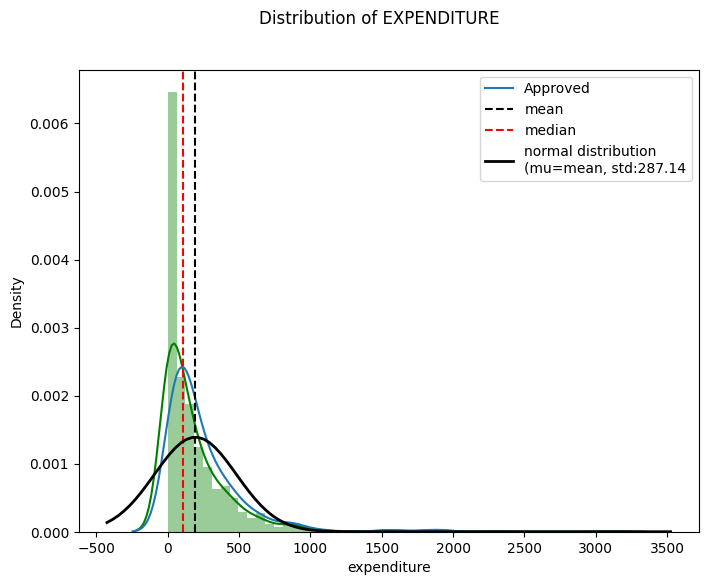

In [50]:
check_dist(numerical_columns[3])

Let's check the applicants with zero expenditure.


In [51]:
print(f"The approval proportion zero expenditure applicants: \n{EDA_df.loc[(EDA_df['expenditure'] == 0)].card.value_counts(normalize=True)}")

The approval proportion zero expenditure applicants: 
no     0.931193
yes    0.068807
Name: card, dtype: float64


Most of them are not approved to have the credit card.

Let's check the minority ones, the approved applicants.


In [52]:
EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')]

,reports,age,income,expenditure,owner,selfemp,dependents,months,majorcards,active,card
71,0,29.00000,2.7000,0.0,no,no,0,24,1,20,yes
233,0,19.50000,2.9800,0.0,no,no,0,18,1,0,yes
241,0,49.16667,1.7000,0.0,no,no,1,14,0,6,yes
410,0,23.00000,2.9000,0.0,no,no,1,12,1,0,yes
451,0,29.08333,2.2000,0.0,no,no,0,9,1,0,yes
510,1,48.75000,2.7000,0.0,no,yes,0,120,1,3,yes
511,0,19.83333,3.0000,0.0,no,no,0,49,1,3,yes
562,0,25.00000,3.3984,0.0,yes,no,2,29,0,4,yes
583,0,61.58333,3.7500,0.0,yes,no,0,288,1,5,yes
759,0,53.50000,1.5000,0.0,yes,no,0,57,0,6,yes


From the table above, they are dominantly not self-employed and already held a credit card.

Perhaps the selfemp and majorcards features are decisive for the applicants with zero expenditure.

To prove it, let's observe the comparison between the approved and the not-approved ones.




In [53]:
print("Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].majorcards.value_counts(normalize=True)}")
print("_________________________________\n")
print("Not-Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].majorcards.value_counts(normalize=True)}")

Approved applicants

Self-employed status: 
no     0.933333
yes    0.066667
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.8
0    0.2
Name: majorcards, dtype: float64
_________________________________

Not-Approved applicants

Self-employed status: 
no     0.901478
yes    0.098522
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.738916
0    0.261084
Name: majorcards, dtype: float64


There is no significant difference, so the `selfemp` and `majorcards` features are not the major decisive detail.

I am determined to keep the zero expenditures data for the training process.


##### dependents


count    903.000000
mean       1.006645
std        1.282649
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 0.0


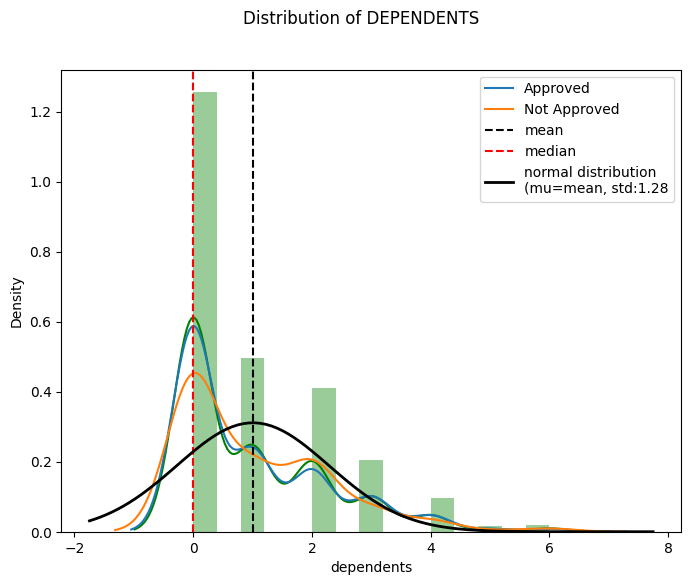

In [54]:
check_dist(numerical_columns[4])


Simply by reading the kdeplot of the approval decision, we can see that the probability of approved application is higher in every value of dependents, except in value 2.

Let's check the approval probability for the applicants in the highest quartile data, who have more than 2 dependents:






In [55]:
print(EDA_df.loc[(EDA_df['dependents'] > 2)].dependents.value_counts()\
                                            .rename_axis('number of dependents')\
                                            .to_frame('counts'))
print("_________________________________\n")
print("Approval decision for applicants with more than 2 dependents")
counts = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts()
counts.name = 'counts'
approval = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)



                      counts
number of dependents        
3                         74
4                         35
6                          7
5                          6
_________________________________

Approval decision for applicants with more than 2 dependents


,%,counts
yes,80.33,98
no,19.67,24


In [56]:
print("Approval proportion of the entire training data")
counts = EDA_df.card.value_counts()
counts.name = 'counts'
approval = EDA_df.card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)



Approval proportion of the entire training data


,%,counts
yes,77.52,700
no,22.48,203


The applicants with more than 2 dependants even have higher possibility to be approved than the entire training data, thus I assume that the `dependents` feature are not the major decisive detail, and will keep it for the training process.


##### months


count    903.000000
mean      54.863787
std       68.573267
min        0.000000
25%       12.000000
50%       30.000000
75%       69.500000
max      540.000000
Name: months, dtype: float64
Median: 30.0


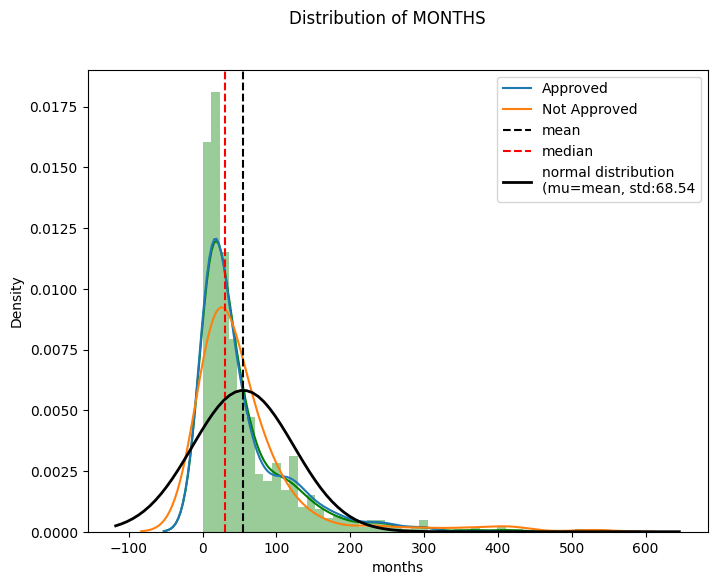

In [57]:
check_dist(numerical_columns[5])

This feature has a very wide range, let's inspect further the far distributed data to specify the outlier.

I roughly set the boundary at value 275.


In [58]:
EDA_df.loc[(EDA_df['months'] > 275)]

,reports,age,income,expenditure,owner,selfemp,dependents,months,majorcards,active,card
111,1,56.91667,3.4838,182.09580,yes,no,0,540,1,7,yes
287,1,55.33333,3.7000,160.45170,yes,no,1,300,1,4,yes
376,1,53.66667,4.1800,0.00000,no,no,1,288,1,2,no
383,1,56.75000,8.0000,0.00000,yes,no,0,408,1,7,no
422,0,61.00000,1.5000,335.56250,yes,no,1,372,1,24,yes
431,1,29.00000,2.7000,0.00000,no,no,1,347,0,1,no
439,0,69.75000,1.8000,0.00000,yes,no,0,528,0,5,no
485,0,25.08333,7.5000,304.38170,yes,no,0,300,1,8,yes
507,2,34.83333,4.9000,0.00000,no,no,2,408,1,3,no
583,0,61.58333,3.7500,0.00000,yes,no,0,288,1,5,yes


There are 12 applicants whose value is more than 275, with 6 of them were approved to have the credit card.

The approved applicants perfectly correlated with the `expenditure` instead of `months`, all applicants with zero expenditure are not approved to have the credit card.

I decide to keep them for the training process.


##### majorcards


count    903.000000
mean       0.821705
std        0.382973
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: majorcards, dtype: float64
Median: 1.0


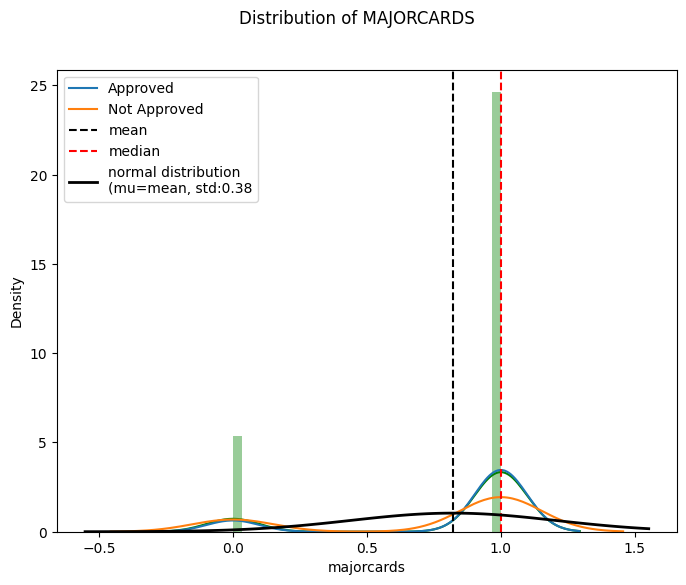

In [59]:
check_dist(numerical_columns[6])


Most applicants already have a credit card.


##### active


count    903.000000
mean       6.929125
std        6.391640
min        0.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       46.000000
Name: active, dtype: float64
Median: 5.0


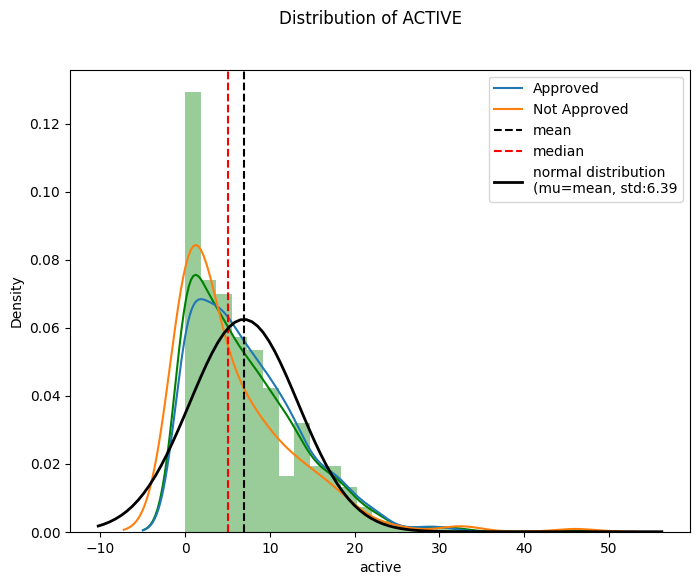

In [60]:
check_dist(numerical_columns[7])

Most applicants have no active credit accounts.


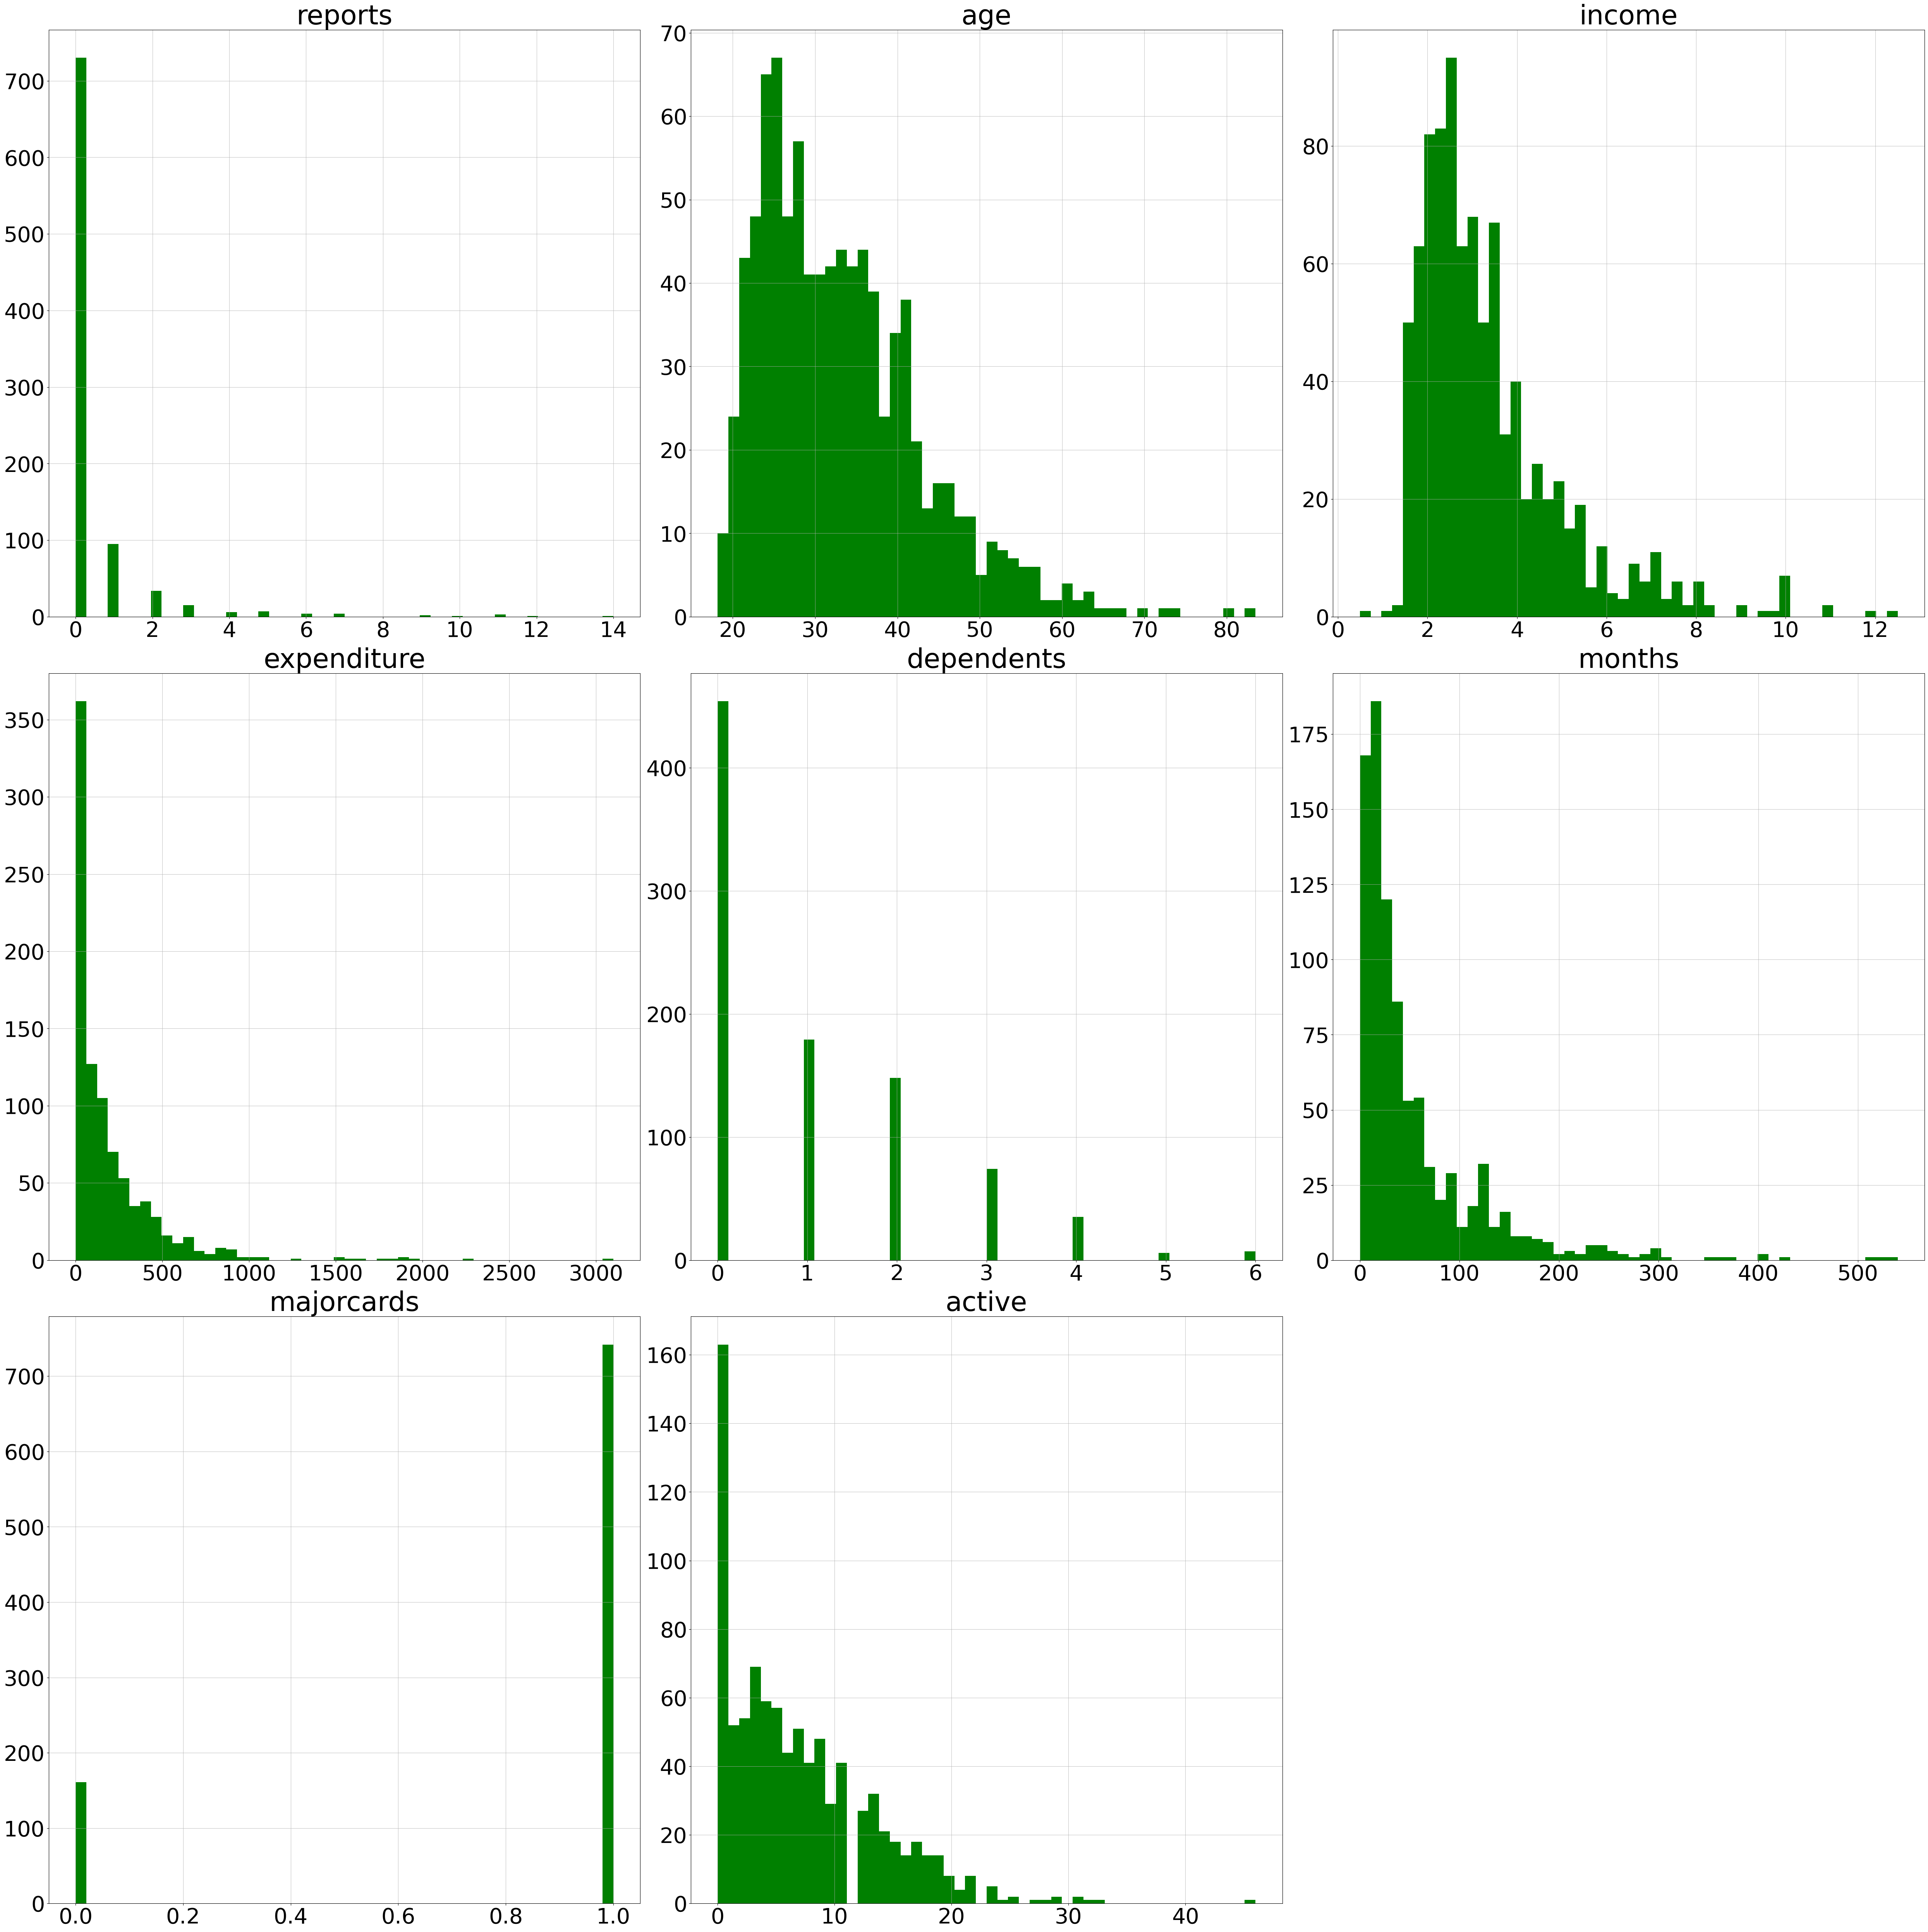

In [61]:
# Visualize the numerical data distribution
draw_histograms(EDA_df, numerical_columns, 3, 3, 50)

Next, I will analyze deeper into the numerical columns.


#### Detail EDA on each feature.


In [62]:
# Create the function for specific numerical column data visualization.
def check_dist(col, bins=50, density=False, plot_normal=True, log_bins=False):
  """A function to visualize the graph for inspecting each feature thoroughly,
  in addition to the basic bar plot of the feature, the graph also shows the normal distribution curve, mean and median vertical lines.
  The correlation to the dependent/target feature is visualized by the KDE plot."""

  x = EDA_df[col]
  TARGET = EDA_df['card']

  fig, ax = plt.subplots(figsize=(8,6))
  fig.suptitle(f"Distribution of {str(col).upper()}")
  sns.distplot(x, axlabel=x.name, color = "green")
  sns.kdeplot(EDA_df.loc[TARGET == "yes", col] , label = 'Approved')
  sns.kdeplot(EDA_df.loc[TARGET == "no", col] ,  label = 'Not Approved')
  line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
  line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
  first_legend = plt.legend(handles=[line1,line2], loc=1)

  if plot_normal == True:
    mu, std = stats.norm.fit(x)
    xmin, xmax = plt.xlim()
    x_norm = np.linspace(xmin, xmax, 100)
    pdf = stats.norm.pdf(x_norm, mu, std)
    ax.plot(x_norm, pdf, 'k', linewidth=2, label=f"normal distribution\n(mu=mean, std:{std:.2f}")

  ax.legend()
  fig.show()
  print(x.describe())
  print("Median:", x.median())

##### reports


count    903.000000
mean       0.449612
std        1.396645
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       14.000000
Name: reports, dtype: float64
Median: 0.0


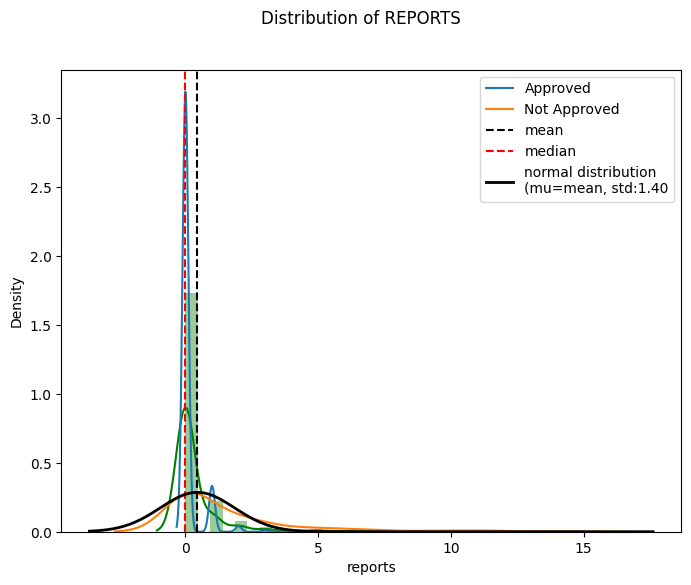

In [63]:
check_dist(numerical_columns[0])

Most applicants have no major derogatory reports.

##### age


count    903.000000
mean      33.228313
std        9.955114
min       18.166670
25%       25.250000
50%       31.500000
75%       38.916670
max       83.500000
Name: age, dtype: float64
Median: 31.5


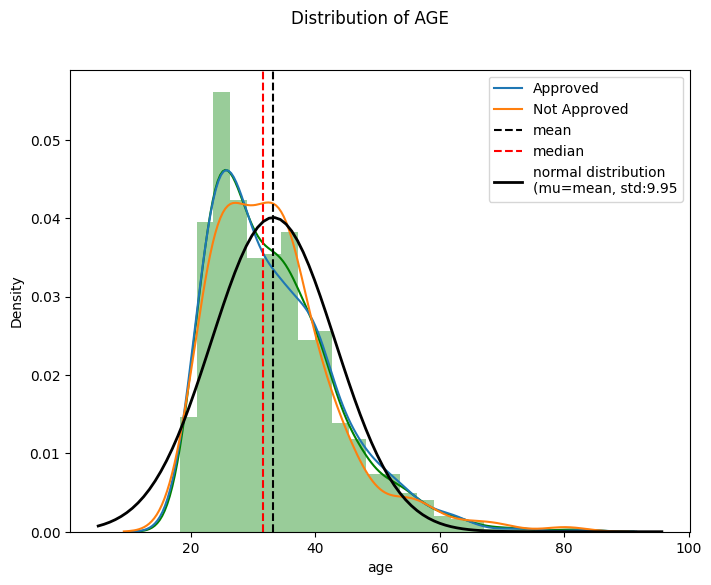

In [64]:
check_dist(numerical_columns[1])

This feature is already handled by dropping the data valued under 18 in the Data Pipeline chapter.


##### income


count    903.000000
mean       3.384004
std        1.678448
min        0.490000
25%        2.250000
50%        2.950000
75%        4.000000
max       12.499900
Name: income, dtype: float64
Median: 2.95


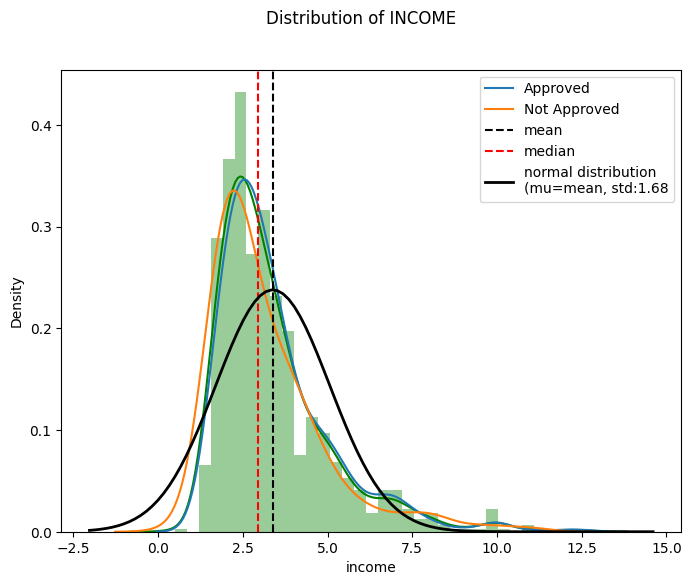

In [65]:
check_dist(numerical_columns[2])

The values shown in this feature are divided by 10,000.

There are some notable occurrence of applicants whose incomes are around 10, we need to inspect it further.


In [66]:
EDA_df.loc[(EDA_df['income'] >= 10)]

,reports,age,income,expenditure,owner,selfemp,dependents,months,majorcards,active,card
85,0,45.58333,11.9999,200.49330,yes,yes,1,24,1,6,yes
359,1,32.50000,10.0000,308.25000,yes,no,3,35,1,4,yes
441,0,31.75000,10.9999,97.42416,no,no,0,12,1,0,yes
584,0,51.58333,12.4999,3099.50500,yes,no,1,120,1,21,yes
645,0,53.00000,11.0000,0.00000,yes,yes,0,429,1,0,no
861,0,43.66667,10.0393,182.82500,yes,no,1,12,1,18,yes


The higher income means the more probable the application to be approved.

Moreover, the applicant's income is more than $100,000 per year, the probability of an application being approved is near 100%.

We can see the exception at the table above, the only one applicant whose income more than $100,000 per year and not approved have zero expenditure.

I decide to keep all the data in this feature, perhaps the model will the threshold of approval decision at 10 or there will be any significant weight from another feature that can affect the approval decision.


##### share


count     903.000000
mean      194.336055
std       287.297197
min         0.000000
25%         5.364583
50%       105.507500
75%       265.921250
max      3099.505000
Name: expenditure, dtype: float64
Median: 105.5075


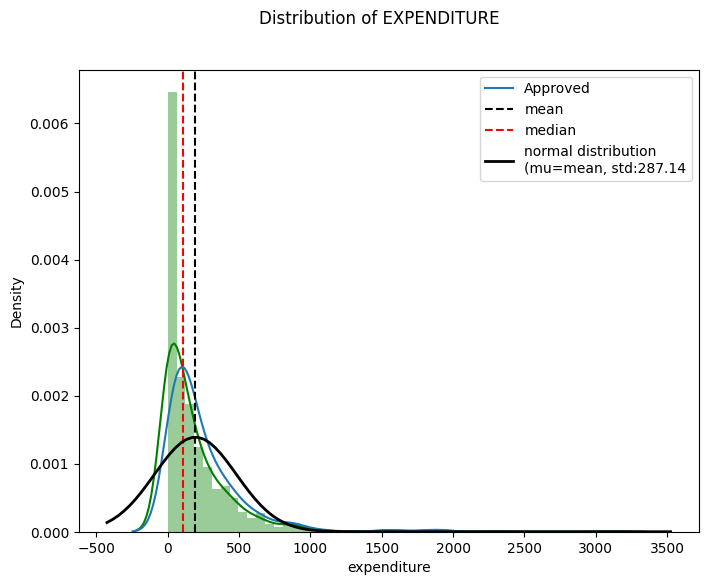

In [67]:
check_dist(numerical_columns[3])

Since I do not get a clear comprehension of the graph, I use the statistical data distribution information to inspect this feature.

Let's inspect the approval proportion from every quartile in this feature.


In [68]:
print(f"The approval proportion of Q4 data: \n{EDA_df.loc[(EDA_df['share'] >= 0.094165)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of Q3 data: \n{EDA_df.loc[(EDA_df['share'] >= 0.0387775) | (EDA_df['share'] <= 0.094165)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of Q1 and Q2 data: \n{EDA_df.loc[(EDA_df['share'] <= 0.0387775)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of the entire training data: \n{EDA_df.card.value_counts(normalize=True)}")


KeyError: 'share'

The higher proportion of income spent via credit card means the more probable the application to be approved.

Moreover, if credit card expenditure is more than 9.4165% of income, the probability of an application being approved is 100%.

I decide to keep all the data in this feature, perhaps the model will set the threshold of approval decision at 0.094165 or there will be any significant weight from another feature that can affect the approval decision.




##### expenditure


count     908.000000
mean      187.984463
std       277.174471
min         0.000000
25%         5.567708
50%       103.152500
75%       250.770800
max      3099.505000
Name: expenditure, dtype: float64
Median: 103.1525


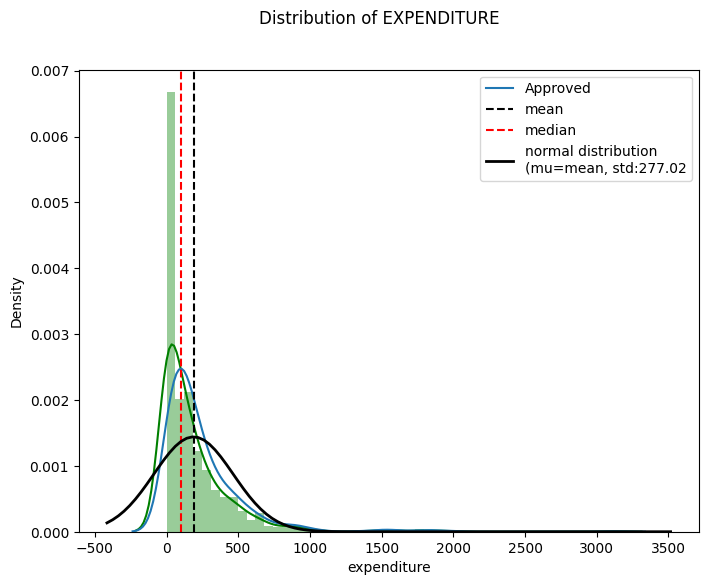

In [ ]:
check_dist(numerical_columns[4])

Let's check the applicants with zero expenditure.


In [ ]:
print(f"The approval proportion zero expenditure applicants: \n{EDA_df.loc[(EDA_df['expenditure'] == 0)].card.value_counts(normalize=True)}")

The approval proportion zero expenditure applicants: 
no     0.940092
yes    0.059908
Name: card, dtype: float64


Most of them are not approved to have the credit card.

Let's check the minority ones, the approved applicants.


In [ ]:
EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')]

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
22,0,29.08333,2.2000,0.000545,0.0,no,no,0,9,1,0,yes
51,0,32.00000,2.4000,0.000500,0.0,no,no,1,11,1,8,yes
81,0,53.50000,1.5000,0.000800,0.0,yes,no,0,57,0,6,yes
126,0,19.83333,3.0000,0.000400,0.0,no,no,0,49,1,3,yes
157,0,23.00000,2.9000,0.000414,0.0,no,no,1,12,1,0,yes
301,0,29.00000,2.7000,0.000444,0.0,no,no,0,24,1,20,yes
321,0,23.75000,1.5678,0.000765,0.0,yes,no,1,6,1,0,yes
374,0,46.75000,2.8000,0.000429,0.0,yes,no,1,84,1,2,yes
505,0,44.66667,2.4000,0.000500,0.0,no,no,0,36,1,11,yes
525,0,49.16667,1.7000,0.000706,0.0,no,no,1,14,0,6,yes


From the table above, they are dominantly not self-employed and already held a credit card.

Perhaps the selfemp and majorcards features are decisive for the applicants with zero expenditure.

To prove it, let's observe the comparison between the approved and the not-approved ones.




In [ ]:
print("Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].majorcards.value_counts(normalize=True)}")
print("_________________________________\n")
print("Not-Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].majorcards.value_counts(normalize=True)}")

Approved applicants

Self-employed status: 
no     0.923077
yes    0.076923
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.769231
0    0.230769
Name: majorcards, dtype: float64
_________________________________

Not-Approved applicants

Self-employed status: 
no     0.906863
yes    0.093137
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.715686
0    0.284314
Name: majorcards, dtype: float64


There is no significant difference, so the `selfemp` and `majorcards` features are not the major decisive detail.

I am determined to keep the zero expenditures data for the training process.


##### dependents


count    908.000000
mean       0.958150
std        1.227402
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 0.0


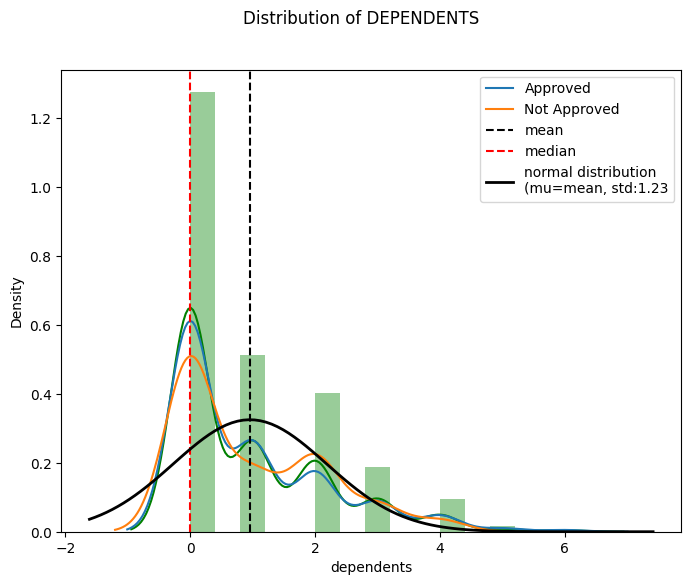

In [ ]:
check_dist(numerical_columns[5])


Simply by reading the kdeplot of the approval decision, we can see that the probability of approved application is higher in every value of dependents, except in value 2.

Let's check the approval probability for the applicants in the highest quartile data, who have more than 2 dependents:






In [ ]:
print(EDA_df.loc[(EDA_df['dependents'] > 2)].dependents.value_counts()\
                                            .rename_axis('number of dependents')\
                                            .to_frame('counts'))
print("_________________________________\n")
print("Approval decision for applicants with more than 2 dependents")
counts = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts()
counts.name = 'counts'
approval = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)



                      counts
number of dependents        
3                         68
4                         35
5                          6
6                          3
_________________________________

Approval decision for applicants with more than 2 dependents


,%,counts
yes,79.46,89
no,20.54,23


In [ ]:
print("Approval proportion of the entire training data")
counts = EDA_df.card.value_counts()
counts.name = 'counts'
approval = EDA_df.card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)



Approval proportion of the entire training data


,%,counts
yes,77.53,704
no,22.47,204


The applicants with more than 2 dependants even have higher possibility to be approved than the entire training data, thus I assume that the `dependents` feature are not the major decisive detail, and will keep it for the training process.


##### months


count    908.000000
mean      53.778634
std       65.321278
min        0.000000
25%       12.000000
50%       30.000000
75%       70.500000
max      540.000000
Name: months, dtype: float64
Median: 30.0


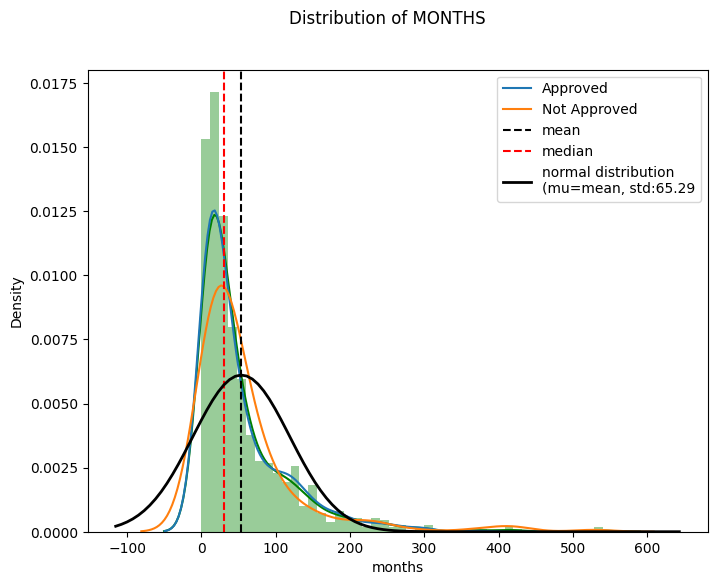

In [ ]:
check_dist(numerical_columns[6])

This feature has a very wide range, let's inspect further the far distributed data to specify the outlier.

I roughly set the boundary at value 275.


In [ ]:
EDA_df.loc[(EDA_df['months'] > 275)]

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
68,0,69.75000,1.8000,0.000667,0.0000,yes,no,0,528,0,5,no
79,1,56.75000,8.0000,0.000150,0.0000,yes,no,0,408,1,7,no
280,0,53.00000,11.0000,0.000109,0.0000,yes,yes,0,429,1,0,no
313,1,55.33333,3.7000,0.052201,160.4517,yes,no,1,300,1,4,yes
331,1,53.66667,4.1800,0.000287,0.0000,no,no,1,288,1,2,no
333,0,49.16667,5.2000,0.146526,634.8625,yes,no,1,303,1,11,yes
393,2,34.83333,4.9000,0.000245,0.0000,no,no,2,408,1,3,no
469,0,47.41667,4.9200,0.044894,183.8983,yes,yes,1,288,1,14,yes
544,0,55.16667,6.7000,0.038585,214.9342,yes,no,1,300,1,13,yes
656,1,56.91667,3.4838,0.062895,182.0958,yes,no,0,540,1,7,yes


There are 12 applicants whose value is more than 275, with 6 of them were approved to have the credit card.

The approved applicants perfectly correlated with the `expenditure` instead of `months`, all applicants with zero expenditure are not approved to have the credit card.

I decide to keep them for the training process.


##### majorcards


count    908.000000
mean       0.806167
std        0.395517
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: majorcards, dtype: float64
Median: 1.0


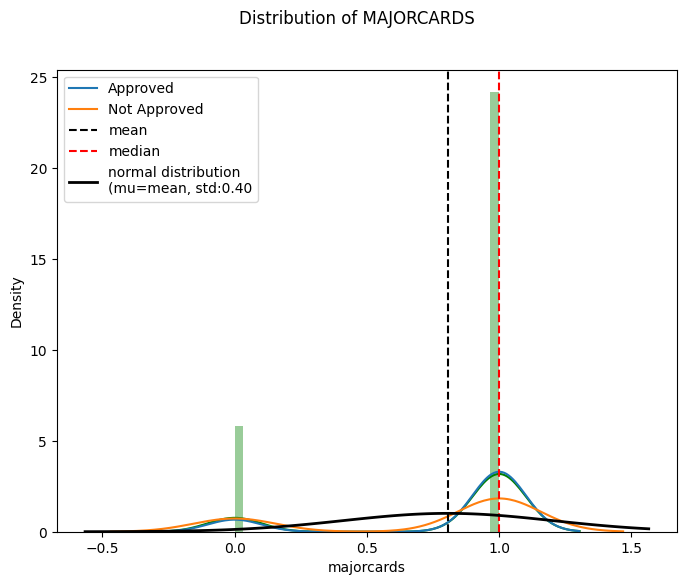

In [ ]:
check_dist(numerical_columns[7])


Most applicants already have a credit card.


##### active


count    908.000000
mean       6.764317
std        6.269012
min        0.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       44.000000
Name: active, dtype: float64
Median: 5.0


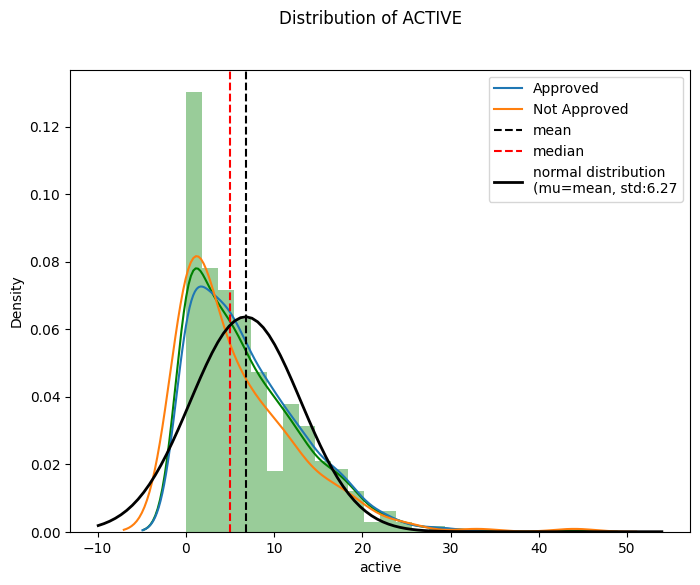

In [ ]:
check_dist(numerical_columns[8])

Most applicants have no active credit accounts.


### Categorical Data Distribution.


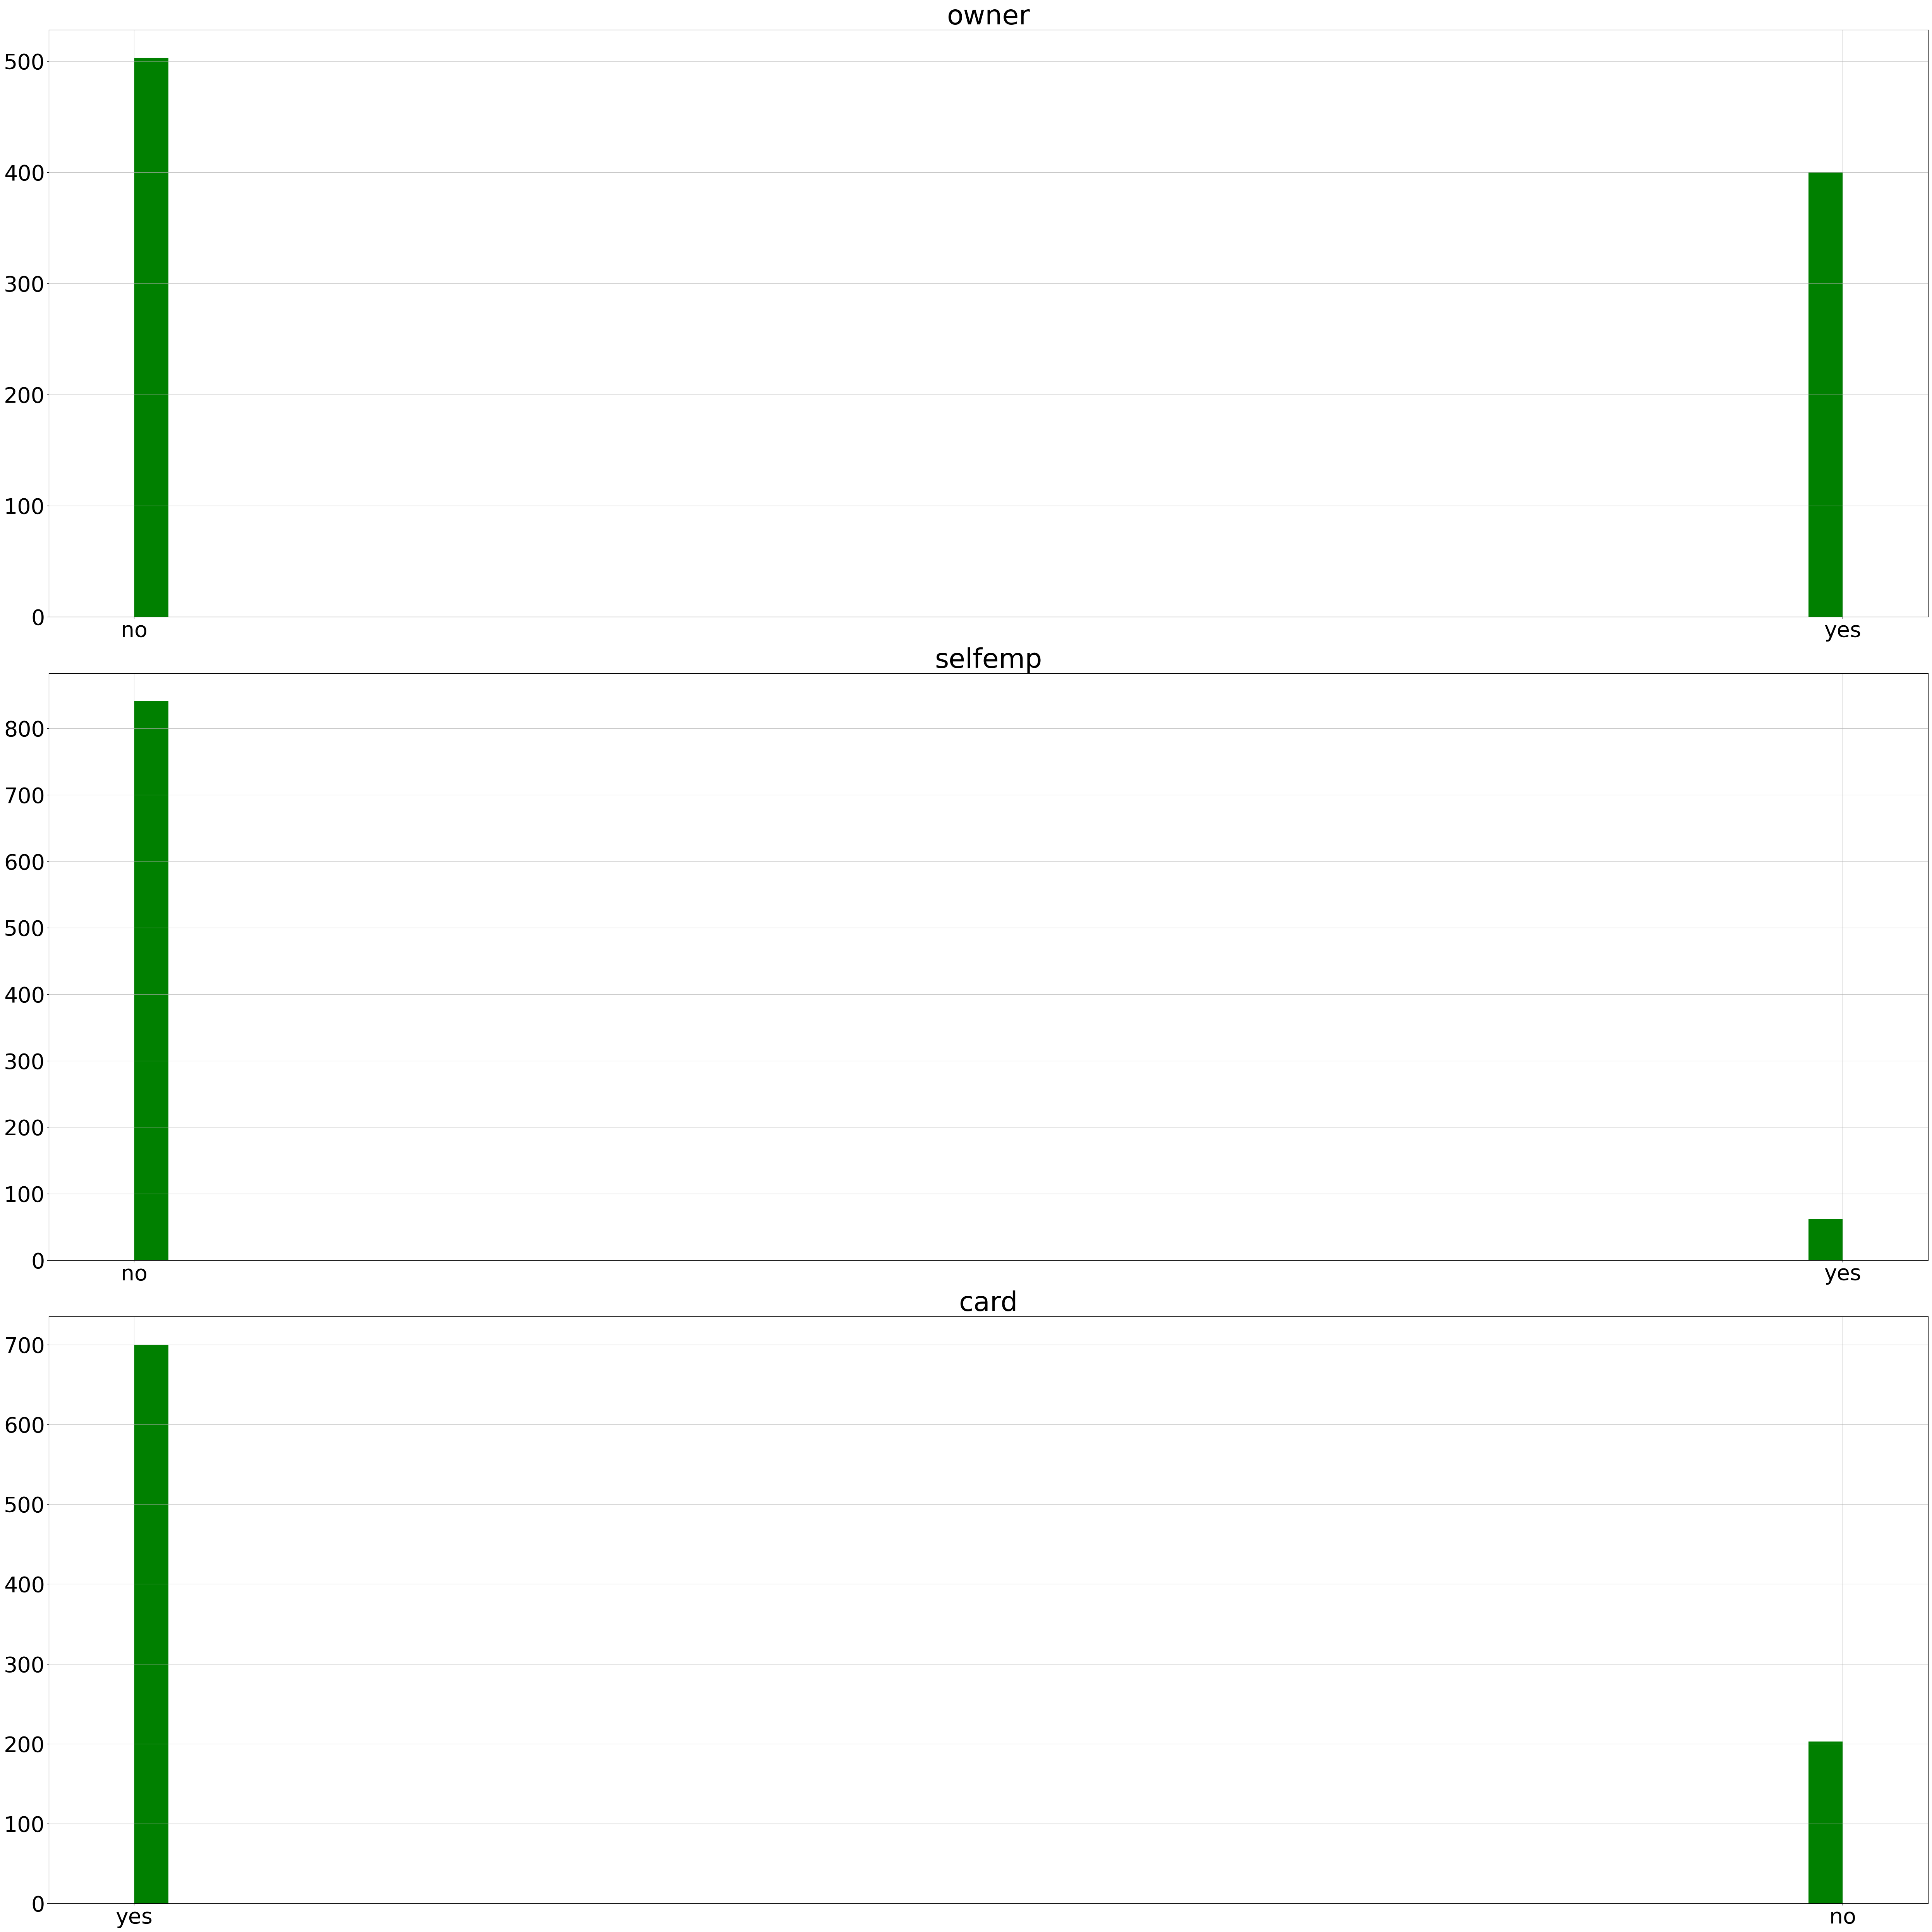

In [ ]:
# Visualize the categorical data distribution
draw_histograms(EDA_df, categorical_columns, 3, 1, 50)


Next, I will analyze deeper into the categorical columns.


#### Detail distribution inspection on each feature.


##### owner


In [ ]:
# Check the distribution and percentage of `owner` feature
print(f"Applicants' home ownership distribution\n{EDA_df['owner'].value_counts()}")
print("-------------------------------------\n")
print(f"Applicants' home ownership percentage\n{EDA_df['owner'].value_counts(normalize = True)*100}")

Applicants' home ownership distribution
no     503
yes    400
Name: owner, dtype: int64
-------------------------------------

Applicants' home ownership percentage
no     55.703212
yes    44.296788
Name: owner, dtype: float64


The applicants whose not own a home are the majority.


##### selfemp


In [ ]:
# Check the distribution and percentage of `owner` feature
print(f"Applicants' self-employment status distribution\n{EDA_df['selfemp'].value_counts()}")
print("-------------------------------------\n")
print(f"Applicants' self-employment status percentage\n{EDA_df['selfemp'].value_counts(normalize = True)*100}")

Applicants' self-employment status distribution
no     841
yes     62
Name: selfemp, dtype: int64
-------------------------------------

Applicants' self-employment status percentage
no     93.133998
yes     6.866002
Name: selfemp, dtype: float64


The self-employed applicants are the significant minority.


## Correlation


### Numerical Columns


<Axes: >

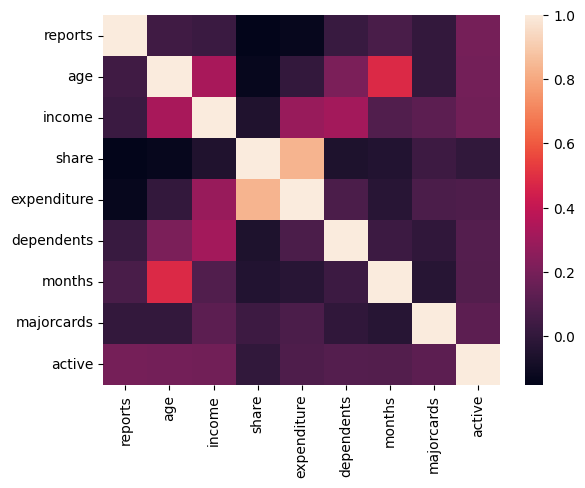

In [ ]:
# print Pearson Correlation heatmap
sns.heatmap(EDA_df.corr(numeric_only = True))

The heatmap above shows the correlation between the numerical features, which from it can be concluded that the closely related features are just between `expenditure` and `share`.

Later in the Feature Engineering chapter, I will convert the `income` feature into a monthly value and multiply by 10,000 to get the real value to conform it with the features `expenditure` and `share`.


### Categorical Columns


#### owner vs card


In [ ]:
CrosstabCount = pd.crosstab(index=EDA_df['owner'],\
                            columns=EDA_df['card'],\
                            margins = True, margins_name = "total")
print(f"Cross-tabulation of owner and card (count):\n \n{CrosstabCount}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['owner'],\
                           columns=EDA_df['card'],\
                           margins = True, margins_name = "total",\
                           normalize = True)*100
print(f"Cross-tabulation of owner and card (percentage):\n \n{CrosstabPerc}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['owner'],\
                           columns=EDA_df['card'],\
                           normalize = 'index')*100
print(f"Cross-tabulation of owner and card (relative percentage of owner):\n \n{CrosstabPerc}")


Cross-tabulation of owner and card (count):
 
card    no  yes  total
owner                 
no     144  359    503
yes     59  341    400
total  203  700    903
-------------------------------------

Cross-tabulation of owner and card (percentage):
 
card          no        yes       total
owner                                  
no     15.946844  39.756368   55.703212
yes     6.533776  37.763012   44.296788
total  22.480620  77.519380  100.000000
-------------------------------------

Cross-tabulation of owner and card (relative percentage of owner):
 
card          no        yes
owner                      
no     28.628231  71.371769
yes    14.750000  85.250000


The applicants whose not own a home are the majority, however the homeowners still have a higher probability to be approved.


#### selfemp vs card


In [ ]:
CrosstabCount = pd.crosstab(index=EDA_df['selfemp'],\
                            columns=EDA_df['card'],\
                            margins = True, margins_name = "total")
print(f"Cross-tabulation of selfemp and card (count):\n \n{CrosstabCount}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['selfemp'],\
                           columns=EDA_df['card'],\
                           margins = True, margins_name = "total",\
                           normalize = True)*100
print(f"Cross-tabulation of selfemp and card (percentage):\n \n{CrosstabPerc}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['selfemp'],\
                           columns=EDA_df['card'],\
                           normalize = 'index')*100
print(f"Cross-tabulation of selfemp and card (relative percentage of selfemp):\n \n{CrosstabPerc}")

Cross-tabulation of selfemp and card (count):
 
card      no  yes  total
selfemp                 
no       183  658    841
yes       20   42     62
total    203  700    903
-------------------------------------

Cross-tabulation of selfemp and card (percentage):
 
card            no        yes       total
selfemp                                  
no       20.265781  72.868217   93.133998
yes       2.214839   4.651163    6.866002
total    22.480620  77.519380  100.000000
-------------------------------------

Cross-tabulation of selfemp and card (relative percentage of selfemp):
 
card            no        yes
selfemp                      
no       21.759810  78.240190
yes      32.258065  67.741935


The self-employed applicants are the significant minority, and their probability to be approved is not pretty high, this feature has a low correlation to the credit card approval decision.

## Conclusion



After the thorough data comprehension, I summarize some further works to be done in the next step (data preprocessing and feature engineering), which are:

+ Data transformation (log-transformation) on `income`, `expenditure`, and `months`.
+ Label Encoding on the categorical features.
+ Data binning on the feature `age`, `reports`, `dependents`, and `active`.
+ Conversion on the `income` data to the original value (multiply by 10,000) and divide it to a monthly value (divide by 12).
+ Category Balancing on the feature `card`.





